#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_423160/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
from efficientnet_pytorch import EfficientNet
import torch.hub

##Define runtime

In [5]:
# !pip install ipython-autotime
%load_ext autotime

time: 198 µs (started: 2024-08-15 23:35:21 +07:00)


##Define GPU usage

In [6]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 79.3 ms (started: 2024-08-15 23:35:21 +07:00)


In [7]:
# Set the GPU device
gpu_index = 7  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 7: Tesla K80
time: 2.42 ms (started: 2024-08-15 23:35:21 +07:00)


#DATA PREPARATION

##Get and Import dataset

In [8]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 3.7 ms (started: 2024-08-15 23:35:21 +07:00)


###Meta-data

In [9]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

image  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000        55.0      anterior torso          NaN  female
1      ISIC_0000001        30.0      anterior torso          NaN  female
2      ISIC_0000002        60.0     upper extremity          NaN  female
3      ISIC_0000003        30.0     upper extremity          NaN    male
4      ISIC_0000004        80.0     posterior torso          NaN    male
...             ...         ...                 ...          ...     ...
25326  ISIC_0073247        85.0           head/neck  BCN_0003925  female
25327  ISIC_0073248        65.0      anterior torso  BCN_0001819    male
25328  ISIC_0073249        70.0     lower extremity  BCN_0001085    male
25329  ISIC_0073251        55.0         palms/soles  BCN_0002083  female
25330  ISIC_0073254        50.0     upper extremity  BCN_0001079    male

[25331 rows x 5 columns]

time: 56.7 ms (started: 2024-08-15 23:35:21 +07:00)


In [10]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 10 columns]

time: 46.9 ms (started: 2024-08-15 23:35:21 +07:00)


In [11]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

image  age_approx anatom_site_general     sex
0     ISIC_0034321        60.0                 NaN  female
1     ISIC_0034322        70.0      anterior torso    male
2     ISIC_0034323        70.0     lower extremity    male
3     ISIC_0034324        70.0     lower extremity    male
4     ISIC_0034325        30.0     upper extremity  female
...            ...         ...                 ...     ...
8233  ISIC_0073236        75.0      anterior torso    male
8234  ISIC_0073243        65.0     lower extremity    male
8235  ISIC_0073250        30.0      anterior torso  female
8236  ISIC_0073252        85.0           head/neck  female
8237  ISIC_0073253        70.0      anterior torso    male

[8238 rows x 4 columns]

time: 19.3 ms (started: 2024-08-15 23:35:21 +07:00)


###Meta-data information

In [12]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 11.5 ms (started: 2024-08-15 23:35:21 +07:00)


In [13]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 7.68 ms (started: 2024-08-15 23:35:21 +07:00)


In [14]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 6.22 ms (started: 2024-08-15 23:35:21 +07:00)


##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 9.31 ms (started: 2024-08-15 23:35:21 +07:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 43 ms (started: 2024-08-15 23:35:21 +07:00)


In [17]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 29.4 ms (started: 2024-08-15 23:35:21 +07:00)


In [18]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  
1459            NV       1.0               Melanocytic Nevi  
1460            NV       1.0               Melanocytic Nevi  
1461            NV       1.0               Melanocytic Nevi  
1462            NV       1.0               Melanocytic Nevi  
1463            NV       1.0               Melanocytic Nevi  
...            ...       ...                            ...  
25326          BCC       1.0           Basal Cell Carcinoma  
25327          BKL       1.0  Benign Keratosis-Like Lesions  
25328          MEL       1.0                       Melanoma  
25329           NV       1.0               Melanocytic Nevi  
25330          BKL       1.0  Benign Keratosis-Like Lesions  

[21311 rows x 8 columns]

time: 20.9 ms (started: 2024-08-15 23:35:21 +07:00)


###Get images data

finish preprocessing

In [19]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  \
1459            NV       1.0               Melanocytic Nevi   
1460            NV       1.0               Melanocytic Nevi   
1461            NV       1.0               Melanocytic Nevi   
1462            NV       1.0               Melanocytic Nevi   
1463            NV       1.0               Melanocytic Nevi   
...            ...       ...                            ...   
25326          BCC       1.0           Basal Cell Carcinoma   
25327          BKL       1.0  Benign Keratosis-Like Lesions   
25328          MEL       1.0                       Melanoma   
25329           NV       1.0               Melanocytic Nevi   
25330          BKL       1.0  Benign Keratosis-Like Lesions   

                                              Image_path  
1459   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1460   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1461   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1462   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1463   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
...                                                  ...  
25326  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25327  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25328  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25329  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25330  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  

[21311 rows x 9 columns]

time: 8.99 s (started: 2024-08-15 23:35:21 +07:00)


In [20]:
# train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 13.2 ms (started: 2024-08-15 23:35:30 +07:00)


###Correctting image paths

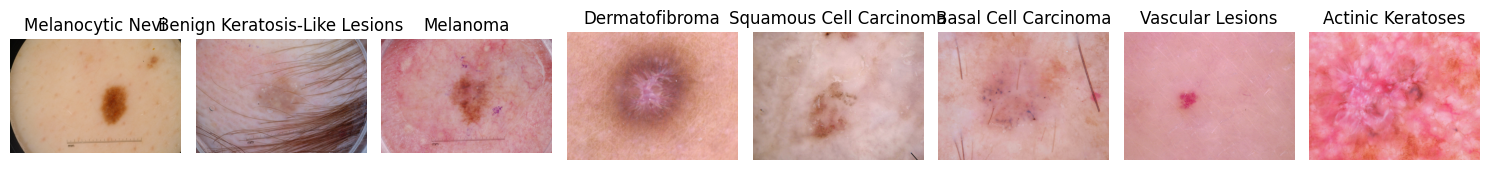

time: 29.6 s (started: 2024-08-15 23:35:30 +07:00)


In [21]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [22]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 7.17 ms (started: 2024-08-15 23:36:00 +07:00)


###Augment and transfrom dataset

In [23]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 18.2 ms (started: 2024-08-15 23:36:00 +07:00)


###Split data

In [24]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 20.3 ms (started: 2024-08-15 23:36:00 +07:00)


###Balancing dataset

In [25]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 56.4 ms (started: 2024-08-15 23:36:00 +07:00)


###Custom dataset class

In [26]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([1, 3, 4, 3, 5, 6, 5, 4, 3, 0, 2, 0, 5, 4, 1, 2, 4, 2, 7, 5, 7, 4, 7, 0,
        3, 2, 4, 7, 6, 5, 1, 5])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 3.06 s (started: 2024-08-15 23:36:00 +07:00)


In [27]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


time: 5.57 s (started: 2024-08-15 23:36:03 +07:00)


##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [28]:
def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'efficientnet-b5':
        model = EfficientNet.from_pretrained('efficientnet-b5')
        num_ftrs = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'resnext50':
        model = models.resnext50_32x4d(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
        model.num_classes = num_classes
    elif model_name == 'shufflenetv2':
        model = models.shufflenet_v2_x1_0(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'dpn68':
        model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn68', pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'customCNN':
        model = CustomCNN(num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet101', 'densenet201', 'efficientnet-b5', 'resnext50_32x4d', 'shufflenetv2', 'dpn68', or 'customCNN'.")
    return model


time: 2.35 ms (started: 2024-08-15 23:36:39 +07:00)


###Training activities

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, threshold=0.5, save_dir='best_model'):
    best_val_loss = np.inf
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': []
    }
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        val_loss = None
        val_acc = None

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, threshold)

            progress_bar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Train Accuracy': f'{train_acc:.2f}%',
                'Val Loss': f'{val_loss:.4f}' if val_loss is not None else '[]',
                'Val Accuracy': f'{val_acc:.2f}%' if val_acc is not None else '[]'
            })
            progress_bar.refresh()

        val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion, threshold)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)

        scheduler.step(val_loss)  # Step the scheduler
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save the best model
            model_save_path = os.path.join(save_dir, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch + 1, # Adjust the epoch number
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, model_save_path)
            
            # Print success message
            print(f'Model {model_name} at epoch {epoch + 1} has been saved to "{model_save_path}" successfully.')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Print overall model accuracy on the validation set
    print(f"Overall Validation Accuracy: {val_acc:.2f}%")
    
    return metrics


time: 3.85 ms (started: 2024-08-15 23:36:46 +07:00)


In [30]:
def validate_model(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)
            confident_preds = (max_probs >= threshold).long() * predicted
            total += labels.size(0)
            correct += (confident_preds == labels).sum().item()

            all_preds.extend(confident_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc, all_preds, all_labels


time: 2.13 ms (started: 2024-08-15 23:36:47 +07:00)


###Visualize training result

In [31]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['Train Loss'], label='Train Loss')
    plt.plot(epochs, metrics['Val Loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

time: 1.91 ms (started: 2024-08-15 23:36:49 +07:00)


In [32]:
def visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))  # Decrease the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {list(label_mapping.keys())[preds[j]]}\n'
                             f'Actual: {list(label_mapping.keys())[labels[j]]}\n'
                             f'Loss: {loss.item():.2f}\n'
                             f'Accuracy: {(preds[j] == labels[j]).item() * 100:.2f}%', fontsize=14)  # Increase text size
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


time: 1.86 ms (started: 2024-08-15 23:36:50 +07:00)


In [33]:
def plot_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

time: 2.09 ms (started: 2024-08-15 23:36:50 +07:00)


In [34]:
def plot_normalize_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

time: 2.46 ms (started: 2024-08-15 23:36:50 +07:00)


##Train the model

In [36]:
# Construct the model for training process
num_classes = len(label_mapping)

model_name = 'resnet50'
model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Transfer learning model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Configuration for training process
num_epochs = 100
threshold = 0.5
patience = 10
save_dir = '../saved_models'  # Save the best model to this location

# Start training
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience, threshold=threshold, save_dir=save_dir)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [28:23<00:00,  1.14it/s, Train Loss=1.8865, Train Accuracy=25.84%, Val Loss=1.7476, Val Accuracy=9.39%]


Model resnet50 at epoch 1 has been saved to "../saved_models/resnet50_best.pth" successfully.


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [28:18<00:00,  1.15it/s, Train Loss=1.7250, Train Accuracy=33.31%, Val Loss=1.7066, Val Accuracy=13.33%]


Model resnet50 at epoch 2 has been saved to "../saved_models/resnet50_best.pth" successfully.


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [27:27<00:00,  1.18it/s, Train Loss=1.5780, Train Accuracy=39.39%, Val Loss=1.5542, Val Accuracy=24.87%]


Model resnet50 at epoch 3 has been saved to "../saved_models/resnet50_best.pth" successfully.


Epoch 4/100:  67%|████████████████████████████████████████████▍                     | 1313/1949 [17:56<07:32,  1.40it/s, Train Loss=1.4810, Train Accuracy=43.25%, Val Loss=1.4284, Val Accuracy=28.44%]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=10.0 (secs)

Epoch 27/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [27:35<00:00,  1.18it/s, Train Loss=0.6163, Train Accuracy=77.01%, Val Loss=1.1051, Val Accuracy=50.49%]


Model resnet50 at epoch 27 has been saved to "../saved_models/resnet50_best.pth" successfully.


Epoch 31/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [27:38<00:00,  1.18it/s, Train Loss=0.6146, Train Accuracy=76.90%, Val Loss=1.0997, Val Accuracy=51.99%]


Epoch    31: reducing learning rate of group 0 to 1.0000e-06.


Epoch 32/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [27:27<00:00,  1.18it/s, Train Loss=0.6535, Train Accuracy=75.73%, Val Loss=1.1024, Val Accuracy=47.30%]


Model resnet50 at epoch 32 has been saved to "../saved_models/resnet50_best.pth" successfully.


Epoch 36/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [28:01<00:00,  1.16it/s, Train Loss=0.6583, Train Accuracy=75.79%, Val Loss=1.1007, Val Accuracy=48.29%]


Epoch    36: reducing learning rate of group 0 to 1.0000e-07.


Epoch 40/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [30:37<00:00,  1.06it/s, Train Loss=0.6908, Train Accuracy=74.59%, Val Loss=1.1188, Val Accuracy=44.53%]


Epoch    40: reducing learning rate of group 0 to 1.0000e-08.


Epoch 42/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [27:58<00:00,  1.16it/s, Train Loss=0.7039, Train Accuracy=74.00%, Val Loss=1.1427, Val Accuracy=43.03%]


Early stopping triggered
Overall Validation Accuracy: 42.80%
time: 19h 43min 56s (started: 2024-08-16 00:11:46 +07:00)


##Visualize training result

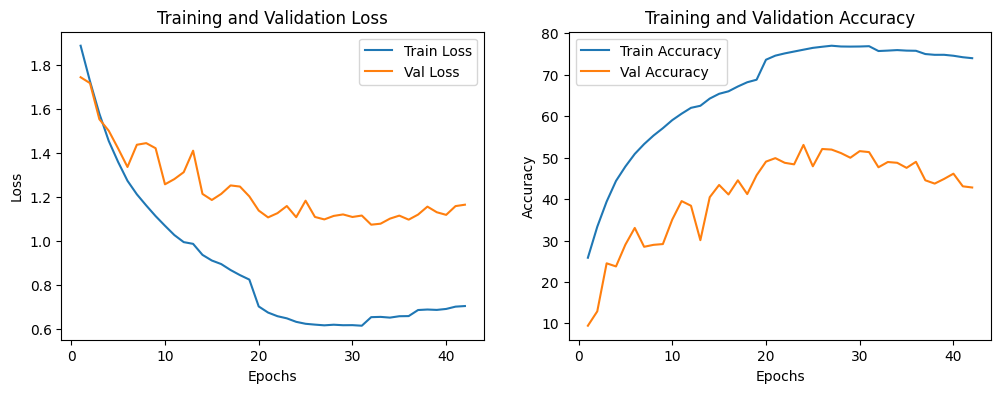

time: 353 ms (started: 2024-08-16 19:55:43 +07:00)


In [37]:
# Visualize the metrics
plot_metrics(metrics)

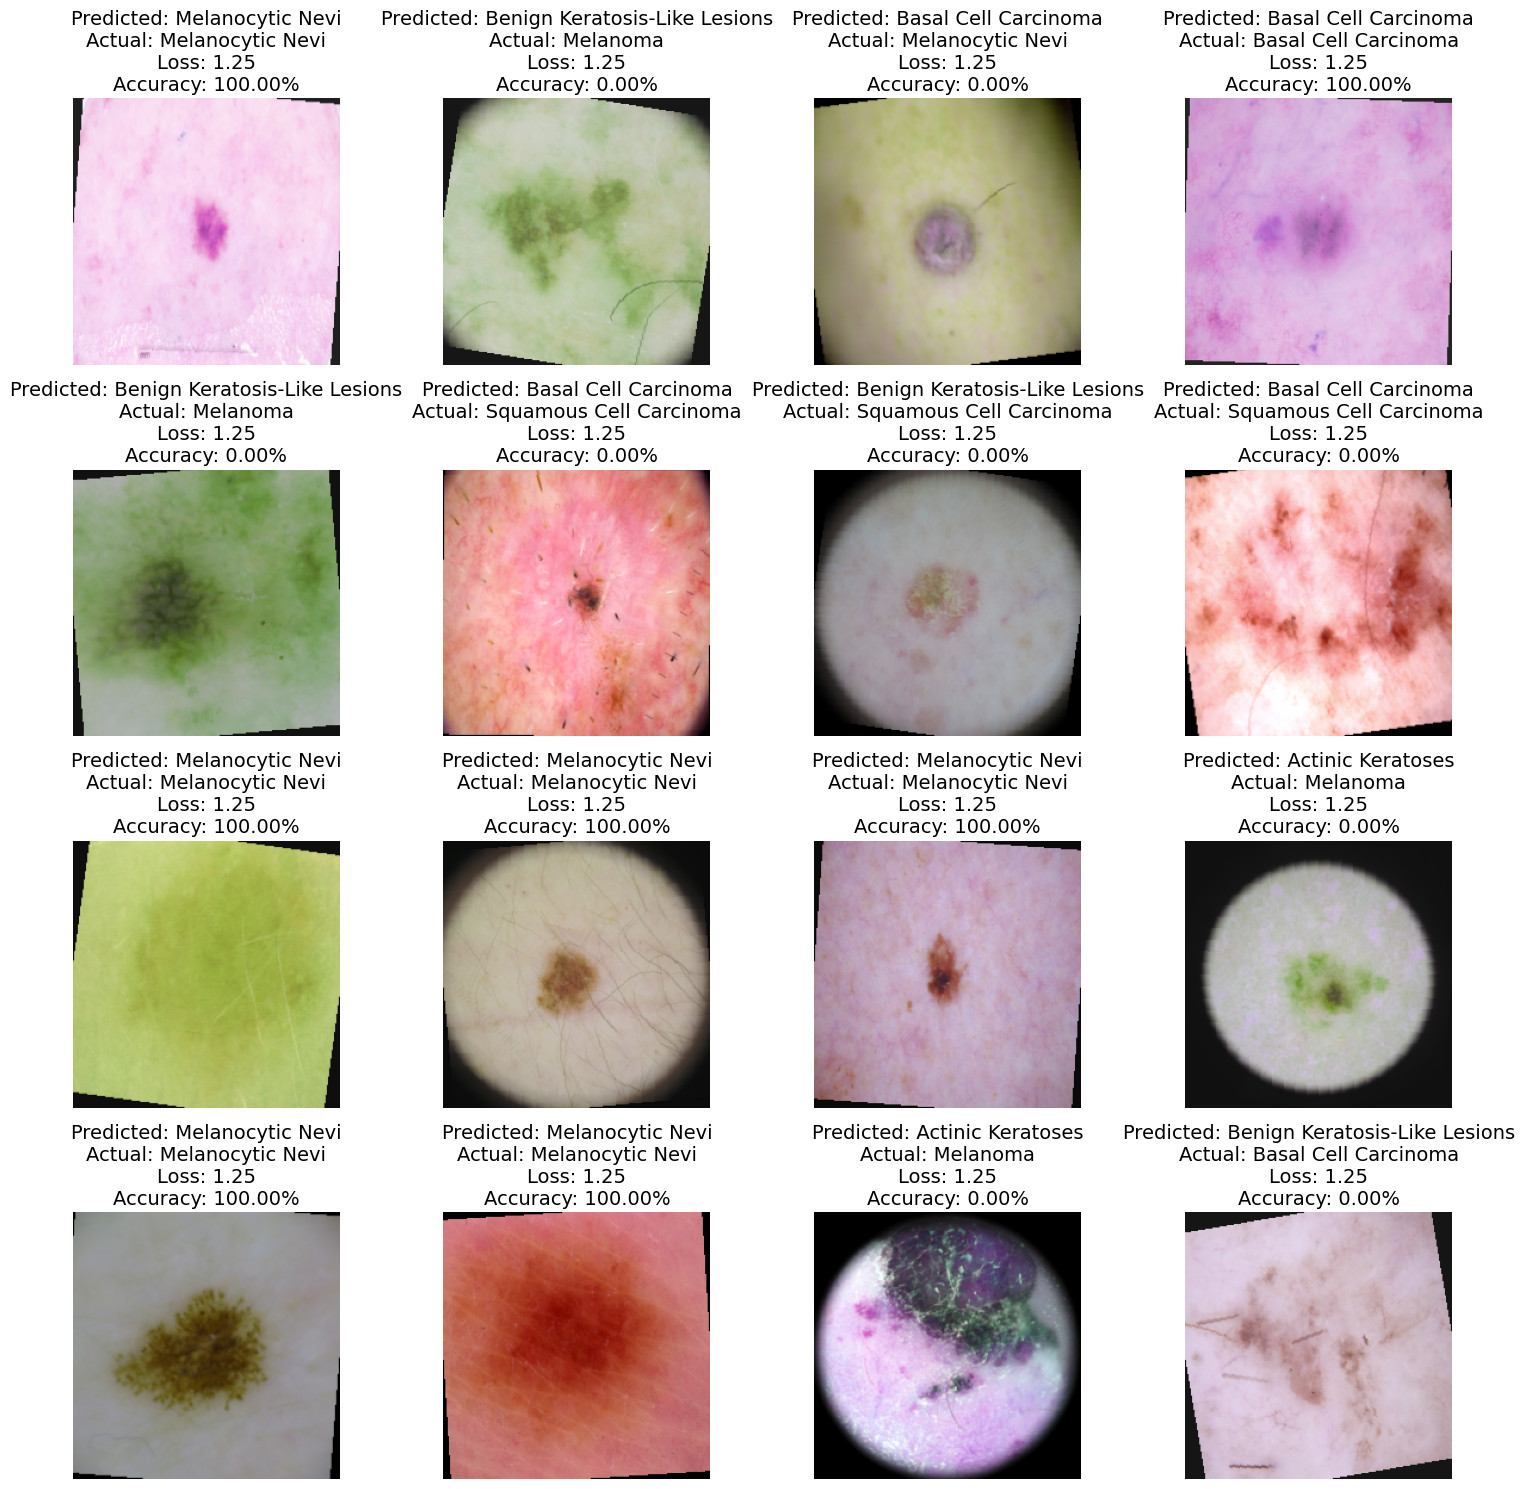

time: 5.13 s (started: 2024-08-16 19:58:10 +07:00)


In [42]:
# Visualize predictions
visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16)

In [48]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

time: 36.7 s (started: 2024-08-16 20:47:42 +07:00)


In [49]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)

time: 39.7 s (started: 2024-08-16 20:51:20 +07:00)
